In [364]:
#Autoreload to be able to tweak source code in the fly without restarting kernel
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
%autoreload 2

In [366]:
import aligater as ag

In [367]:
fcsList=ag.collectFiles("/media/ludvig/Project_Storage/GAIM/data/GAIM_fcs/", lFilter=["B cells"])

Collected 3022 files, 6347 files did not pass filter(s) and mask(s).


In [368]:
fcsDF = ag.loadFCS(fcsList[1], compensate=True)

Opening file B cells_A2_A02_030 from folder /01-03-2016/plate 1
Loaded dataset with 279440 events.
Marker labels: IgA CD27 CD34 CD19 IgD CD45 CD38 CD24 


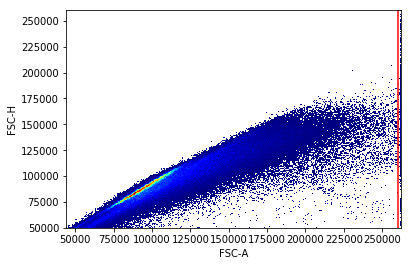

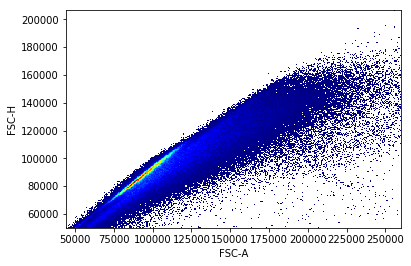

After gating, 277035 out of 279440 events remain.


In [369]:
no_clutter=ag.gateThreshold(fcsDF,"FSC-A", "FSC-H",thresh=260000, orientation='vertical',population="lower")

After gating, 271409 out of 277035 events remain.


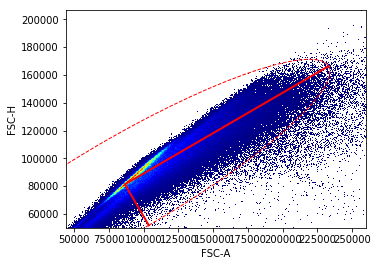

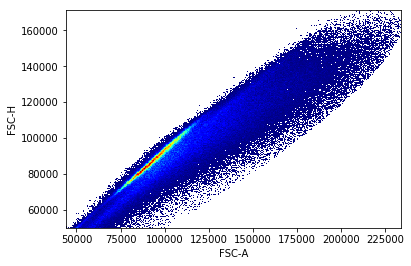

In [370]:
singlets=ag.gatePC(fcsDF,"FSC-A", "FSC-H",center='density',widthScale=4, heightScale=4, vI=no_clutter, plot=True)

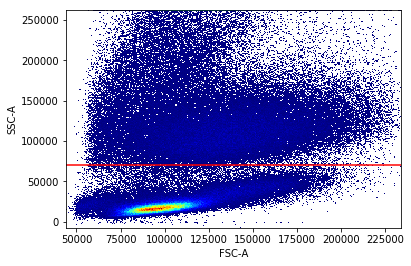

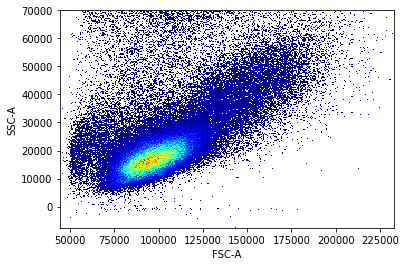

After gating, 139650 out of 271409 events remain.


In [371]:
PBMCstep1=ag.gateThreshold(fcsDF,xCol="FSC-A",yCol="SSC-A",vI=singlets, orientation="horisontal",thresh=70000,population="lower")

After gating, 128561 out of 139650 events remain.


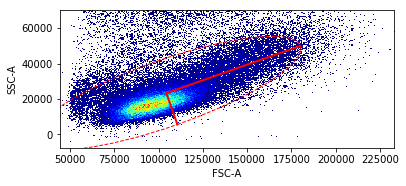

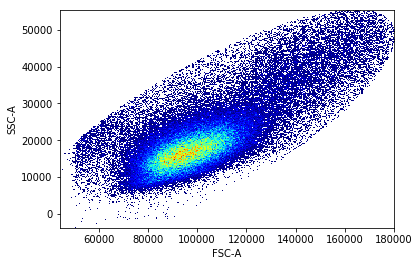

In [372]:
PBMC=ag.gatePC(fcsDF,"FSC-A","SSC-A",center='centroid',widthScale=3, heightScale=2, vI=PBMCstep1, plot=True)

In [373]:
mean, sigma, maxVal=ag.axisStats(fcsDF, "CD34", PBMC)
sigma*3

2467.6315842645172

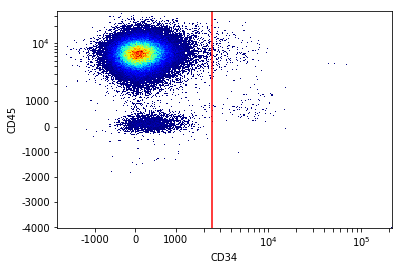

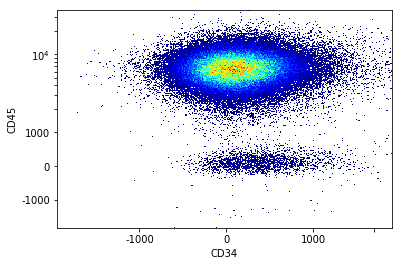

After gating, 128159 out of 128561 events remain.


In [374]:
CD45step1 = ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='vertical', vI=PBMC,population="lower",thresh=3*sigma, scale='logish')

In [375]:
lim = ag.valleySeek(fcsDF, "CD45",vI=CD45step1,interval=[0,2500],sigma=2,bins=1000)

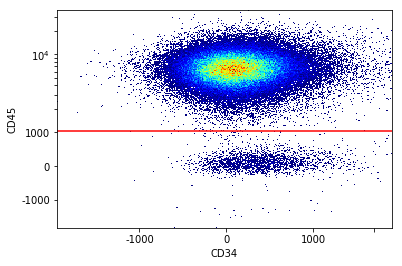

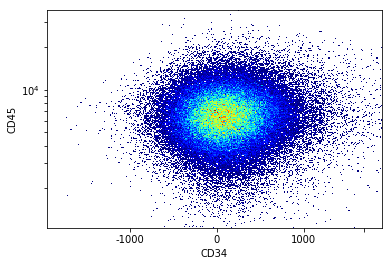

After gating, 124948 out of 128159 events remain.


In [376]:
CD45pos = ag.gateThreshold(fcsDF, "CD34", "CD45", vI=CD45step1, orientation='horisontal',thresh=lim,scale='logish') 

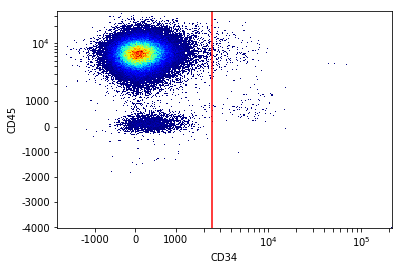

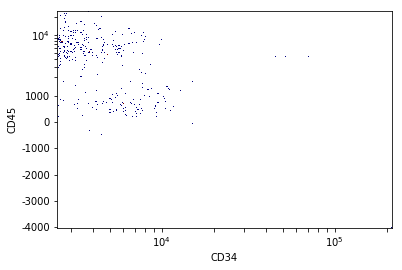

After gating, 402 out of 128561 events remain.


In [377]:
CD34step1=ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='vertical', vI=PBMC,population="upper",thresh=3*sigma, scale='logish')

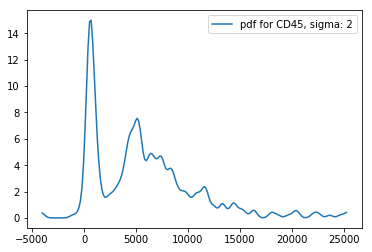

In [378]:
ag.plot_densityFunc(fcsDF,"CD45", vI=CD34step1,sigma=2,bins=200)

In [379]:
lim=ag.valleySeek(fcsDF, "CD45",vI=CD34step1,interval=[500,2500],sigma=2,bins=200)
lim

2049.6028745987392

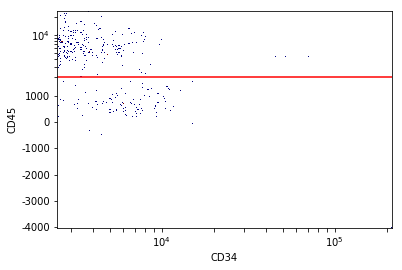

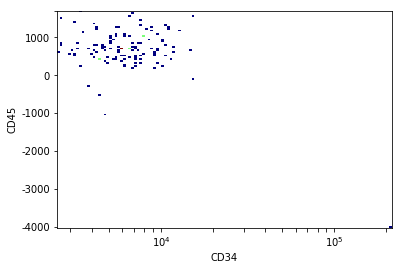

After gating, 122 out of 402 events remain.


In [380]:
CD34pos=ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='horisontal', vI=CD34step1,population="lower",thresh=lim, scale='logish')

(<matplotlib.figure.Figure at 0x7fd1a089b0b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1a2573198>)

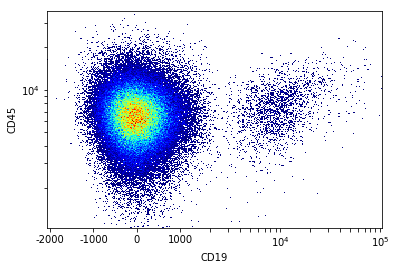

In [381]:
ag.plotHeatmap(fcsDF, "CD19","CD45",vI=CD45pos,scale='logish')

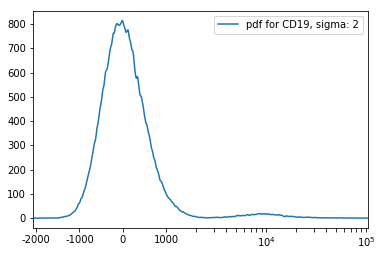

In [382]:
ag.plot_densityFunc(fcsDF,xCol="CD19",vI=CD45pos, bins=1000, sigma=2, scale='logish')

In [383]:
lim=ag.valleySeek(fcsDF,xCol="CD19",vI=CD45pos,interval=[0,2000],bins=1000,sigma=2, scale='logish')

In [384]:
lim

1999.3197230788846

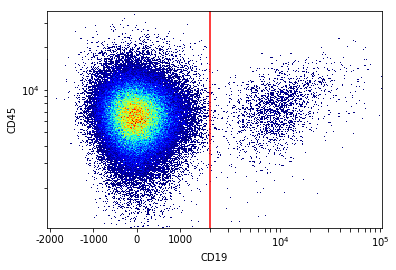

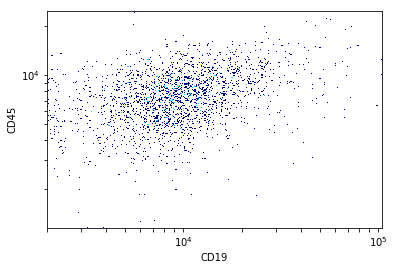

After gating, 2943 out of 124948 events remain.


In [385]:
CD19pos=ag.gateThreshold(fcsDF,"CD19","CD45",vI=CD45pos,thresh=lim,scale='logish',orientation='vertical',population='upper')

(<matplotlib.figure.Figure at 0x7fd1a1ddb438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1aa1c7978>)

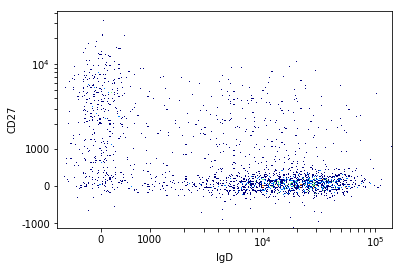

In [386]:
ag.plotHeatmap(fcsDF, "IgD", "CD27", vI=CD19pos,scale="logish",bins=300)

In [387]:
xlim=ag.valleySeek(fcsDF,"IgD", CD19pos, interval=[500,2500],bins=300,sigma=2, scale='logish')

In [388]:
ylim=ag.valleySeek(fcsDF,"CD27", CD19pos, interval=[500,1000],bins=300,sigma=2, scale='logish')

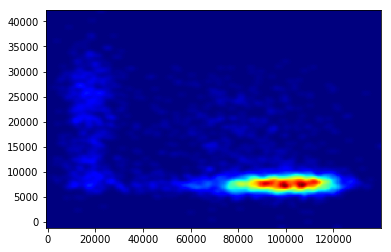

Input quadgate solution score: 0.0471400690977
Tested 20 solution(s) excluding the input solution
Best solution had score: 0.0471400690977


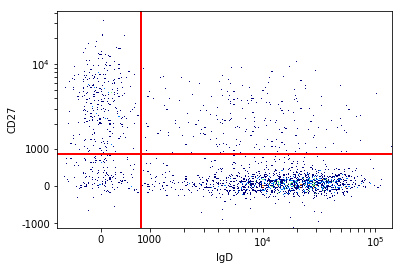

In [389]:
switchB, preSwitchB, naiveB, exhaustedB,solution = ag.variableQuadGate(fcsDF, "IgD", "CD27", [xlim, xlim, ylim, ylim], testRange=[500,7000], position='left', vI=CD19pos,scale='logish', plot=True)

(<matplotlib.figure.Figure at 0x7fd1a2065eb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1a1960208>)

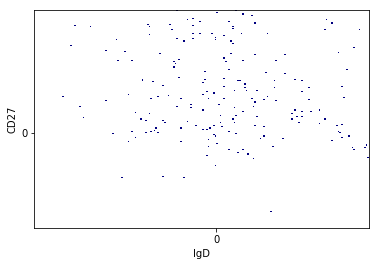

In [390]:
ag.plotHeatmap(fcsDF, "IgD", "CD27", vI=exhaustedB, scale='logish')

In [391]:
mean, sigma, maxVal = ag.axisStats(fcsDF, "CD38", vI=switchB)

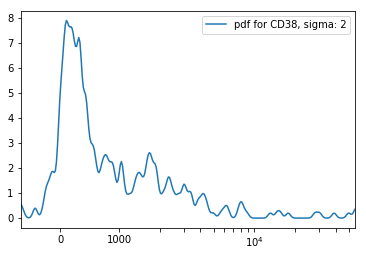

In [392]:
ag.plot_densityFunc(fcsDF,"CD38",switchB,scale='logish',bins=300,sigma=2)

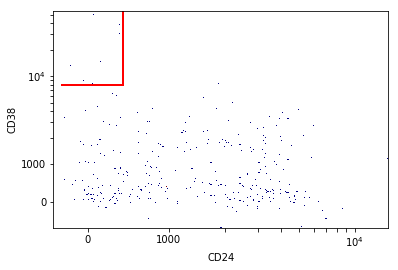

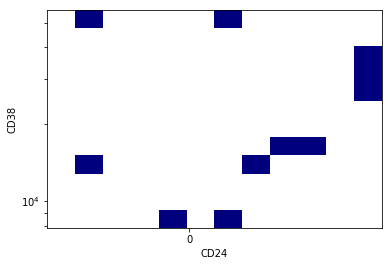

After gating, 12 out of 392 events remain.


In [393]:
plasmablasts=ag.gateCorner(fcsDF, "CD24", "CD38",1000,mean+sigma,"lower","upper", vI=switchB,scale='logish')

In [394]:
xmean,xsigma,xmaxVal = ag.axisStats(fcsDF,xCol="CD24",vI=naiveB)

In [395]:
ymean,ysigma,ymaxVal = ag.axisStats(fcsDF,xCol="CD38",vI=naiveB)

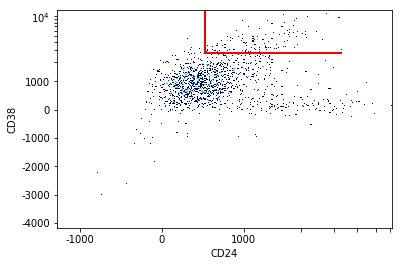

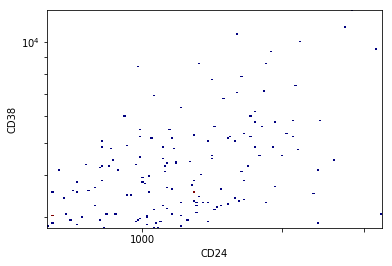

After gating, 149 out of 2063 events remain.


In [396]:
transitionals=ag.gateCorner(fcsDF,"CD24", "CD38",xThresh = xmaxVal, yThresh=ymaxVal+2000, vI=naiveB, scale='logish')

In [397]:
lim = ag.valleySeek(fcsDF,"IgA",vI=switchB,interval=[750,2000],bins=300, sigma=1, scale='logish')
lim

1707.9674766188473

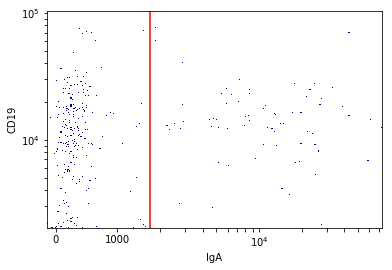

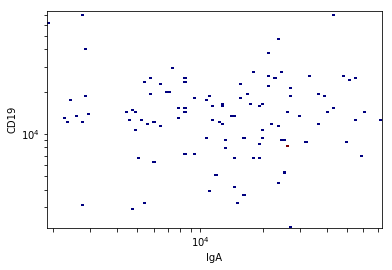

After gating, 108 out of 392 events remain.


In [398]:
IgApos=ag.gateThreshold(fcsDF, "IgA","CD19", orientation='vertical', vI=switchB, thresh=lim, scale='logish')